This script should calculate the heat budget in for both cartesian and residual mean.

# Cartesian

The heat budget can written in the familiar form:
\begin{equation}
\frac{\partial T}{\partial t} + \nabla \cdot \textbf{u}T = \frac{\partial Q}{\partial z}
\end{equation}
 Where Q is the surface heat flux. Using a Reynolds decomposition to split the budget into eddy and mean transport terms gives:
 
\begin{equation}
\frac{\partial \overline{v}\overline{T}}{\partial y } + \frac{\partial \overline{w}\overline{T}}{\partial z } + \frac{\partial \overline{v'T'}}{\partial y } + \frac{\partial \overline{w'T'}}{\partial z } = \frac{\partial Q}{\partial z}.
\end{equation}

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import csv
import sys
from scipy.interpolate import interp1d
from scipy import interpolate
from numba import autojit
import numdifftools as nd
import numdifftools.nd_algopy as nda
from pylab import *
from matplotlib import gridspec
import netCDF4
sys.path.append('/noc/users/hb1g13/Python/python_functions/')
from useful import *
from Flat_channel import *
from HB_Plot import nf, fmt
import SG as SG
sys.path.append('/noc/users/hb1g13/Python/python_functions/MITgcmUtils/')
import utils
%matplotlib inline

In [2]:
# Some parameters
Full = 'N'  # 9 Pannels isn't ideal for presentations N option give 4 plots


In [6]:
tau = ['50', '250', '500', '2000']
#tau = ['50', '250', '500' , '1000', '2000']
Figletter = ['a) ','b) ','c) ','d) ','e)','f)','g)','h)','j)']
# Path root
x = '/noc/msm/scratch/students/hb1g13/Mobilis/Vary_N/'
# Now Make file structure
check = 0
runs = []
for i in range(len(tau)):
    flist = x+'/'+str(tau[i])+'m/PSI.nc'
    if not os.path.exists(flist):
        print ' WARNING: '+flist+' does not exist! (skipping this tau...)'
        check += 0
    else:
        check += 1
        runs.append(i)
Runs=np.array(runs)

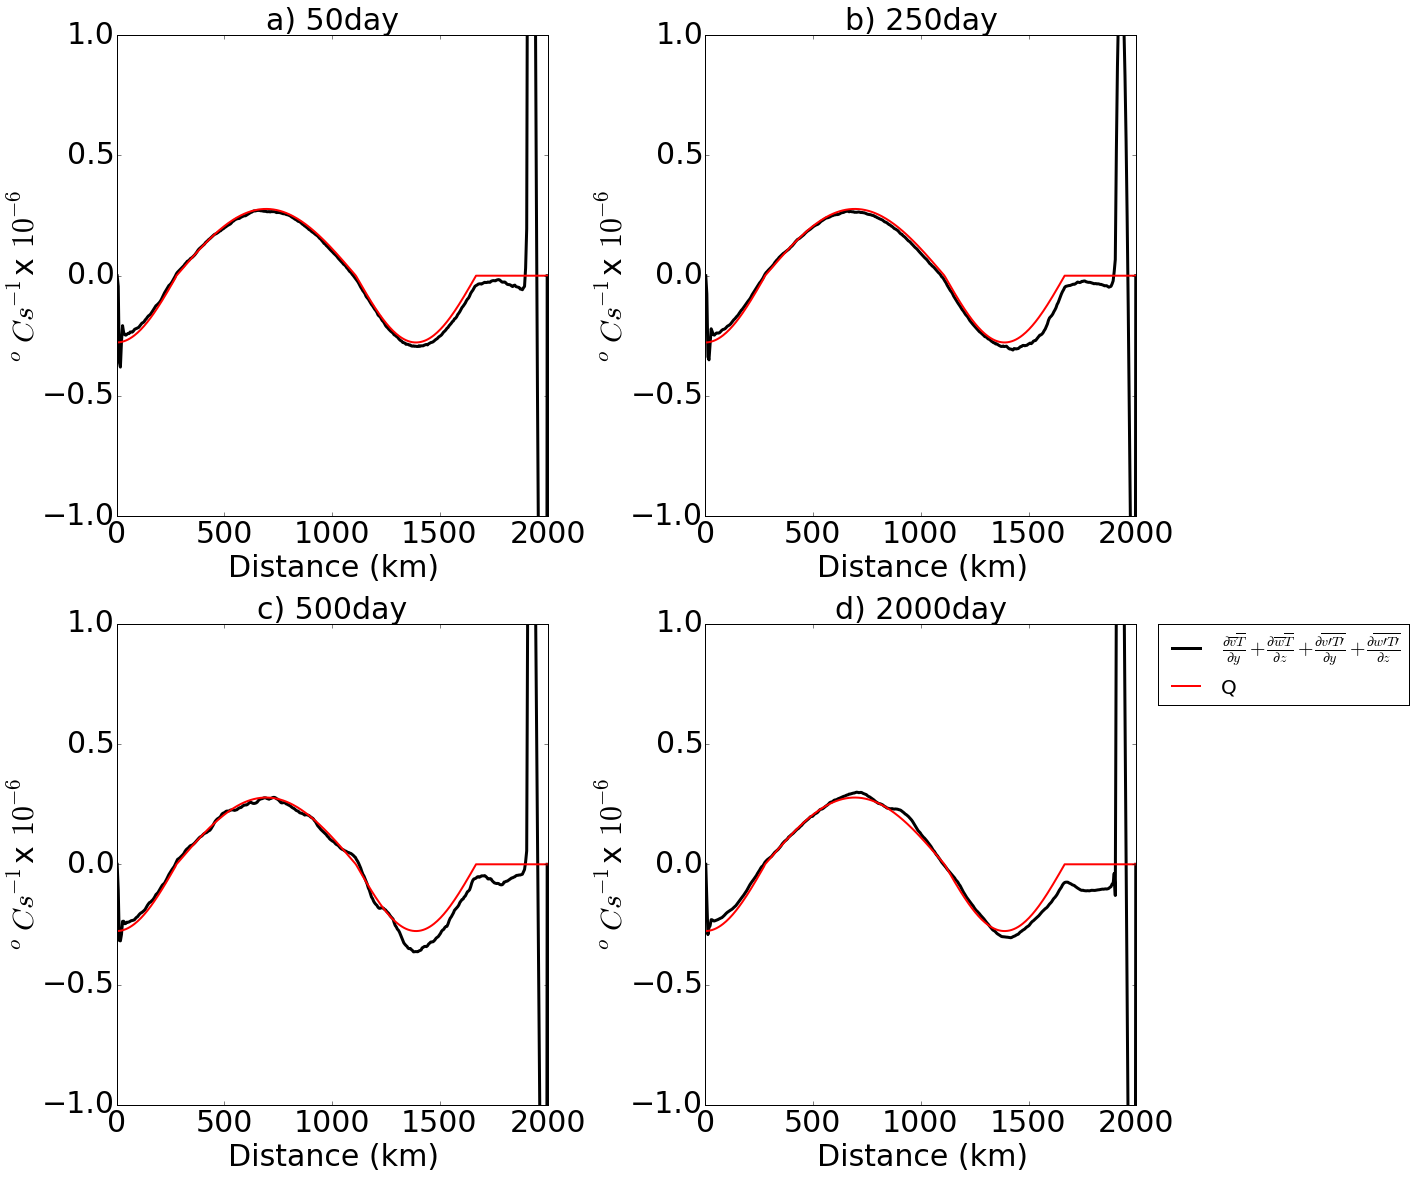

In [7]:
fig = plt.figure(figsize=(16.5, 16.5))
for i in range(len(Runs)):
    fname = x+'/'+str(tau[Runs[i]])+'m/'
    
    c = utils.ChannelSetup(output_dir=str(fname))
    # PLOT PANNELS
    CellVol = c.rac*tile(c.dzf,(c.Nx,c.Ny,1)).T
    Nx,Ny,Nz = c.Nx, c.Ny, c.Nz
    # load V, W, T bar                                                   
    # put everything on the C Grid                                                         
    VT = (c.mnc('Tav_VT.nc','VVELTH'))
    WT = (c.mnc('Tav_VT.nc','WVELTH'))
    Tv = c.cgrid_to_vgrid(c.mnc('Tav.nc','THETA'))
    Tw = c.cgrid_to_wgrid(c.mnc('Tav.nc','THETA'))
    V = (c.mnc('Tav.nc','VVEL'))
    W = (c.mnc('Tav.nc','WVEL'))
    VTbar = V*Tv
    WTbar = W*Tw
    VpTp = VT - VTbar
    WpTp = WT - WTbar
    # Vertical Mass-Weight Transp of Pot Temp (K.m/s)
    WTHMASS = c.mnc('SURF.nc', 'WTHMASS')
    # Surface cor
    Surcor = (WTHMASS.mean(axis=0)).mean(axis=1)
    dVTbar = (VTbar[:,0:-1,:] - VTbar[:,1::,:])*CellVol
    dWTbar = (WTbar[1::,:,:] - WTbar[0:-1,:,:])*CellVol[0:-1,:,:]
    dVTe = (VpTp[:,0:-1,:] - VpTp[:,1::,:])*CellVol
    dWTe = (WpTp[1::,:,:] - WpTp[0:-1,:,:])*CellVol[0:-1,:,:]
    Adv = (dVTe.sum(axis=0) + dWTe.sum(axis=0) + dVTbar.sum(axis=0) + dWTbar.sum(axis=0))/sum(CellVol)
    Diff = -(5000*Adv).mean(axis=1)
    Ly = 2000e3
    Lx = 1000e3
    nx = np.round(Lx/5000)
    ny = np.round(Ly/5000)
    Q_0 = 10
    Q = np.zeros_like(c.yc)
    pi = math.pi
    Q=np.zeros(np.shape(Q))
    Q[0:int(5*ny/36)] = Q_0*(np.cos(c.yc[0:int(5*ny/36)]*(pi/(c.yc[int(10*ny/36)]))))
    Q[int(5*ny/36):int(20*ny/36)] = -Q_0*(np.sin((c.yc[int(5*ny/36):int(20*ny/36)]-
                                                  c.yc[int(5*ny/36)])*(pi/(c.yc[int(15*ny/36)]))))
    Q[int(20*ny/36):int(30*ny/36)] = Q_0*(np.sin(c.yc[0:int(10*ny/36)]*(pi/(c.yc[int(10*ny/36)]))))
    Psipred = -(Q)/(1000*3985)
    ax = fig.add_subplot(2, 2, i+1)
    p = plt.plot(c.yc/1000,(Diff+Surcor)*10**6,'k',linewidth=3)
    p = plt.plot(c.yc/1000,(Psipred/c.dzf[6])*10**6,'r',linewidth=2)
    plt.ylim(-1,1)
    ax.set_title(str(Figletter[Runs[i]])+str(tau[Runs[i]])+'day', fontsize=30)
    if str(tau[Runs[i]]) == 'Closed':
        ax.set_title(str(Figletter[Runs[i]])+str(tau[Runs[i]]), fontsize=30)
    ax.set_xlabel('Distance (km)', fontsize=30)
    ax.set_ylabel(r'$^oCs^{-1}$x $10^{-6}$', fontsize=30)
    ax.tick_params(axis='both', which='major', labelsize=30)
lgd = plt.legend([r'$\frac{\partial\overline{v}\overline{T}}{\partial y}+\frac{\partial\overline{w}\overline{T}}{\partial z}+\frac{\partial \overline{v\prime T\prime }}{\partial y} + \frac{\partial \overline{w\prime T\prime }}{\partial z} $'
                  ,'Q'],bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.,fontsize=20)
plt.tight_layout()

 The $\overline{v'T'}$ and $\overline{w'T'}$ terms can be decomposed into an along-isopycnal term and a horizontal component:

\begin{equation}
\left( \overline{v'T'},\overline{w'T'} \right) =  \underbrace{\left( \overline{v'T'}, \overline{v'T'}S_p \right)}_\text{along $\overline{T}$}  + \underbrace{\left( 0, \overline{w'T'}-\overline{v'T'}S_p \right)}_\text{remaining vertical}, 
\end{equation}

which can be substituted back in to the heat budget:
\begin{equation}
\frac{\partial \overline{v}\overline{T}}{\partial y } + \frac{\partial\overline{w} \overline{T}}{\partial z } + \frac{\partial \overline{v'T'}S_p}{\partial z } + \frac{\partial \overline{v'T'}}{\partial y } = \frac{\partial Q}{\partial z}+ \frac{\partial \left( \overline{w'T'}-\overline{v'T'}S_p \right)}{\partial z }.
\end{equation}



/noc/users/hb1g13/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:32: RuntimeWarning: divide by zero encountered in divide
/noc/users/hb1g13/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:32: RuntimeWarning: invalid value encountered in divide
/noc/users/hb1g13/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:33: RuntimeWarning: invalid value encountered in multiply
/noc/users/hb1g13/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:34: RuntimeWarning: invalid value encountered in multiply
/noc/users/hb1g13/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:35: RuntimeWarning: invalid value encountered in multiply
/noc/users/hb1g13/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:36: RuntimeWarning: invalid value encountered in multiply


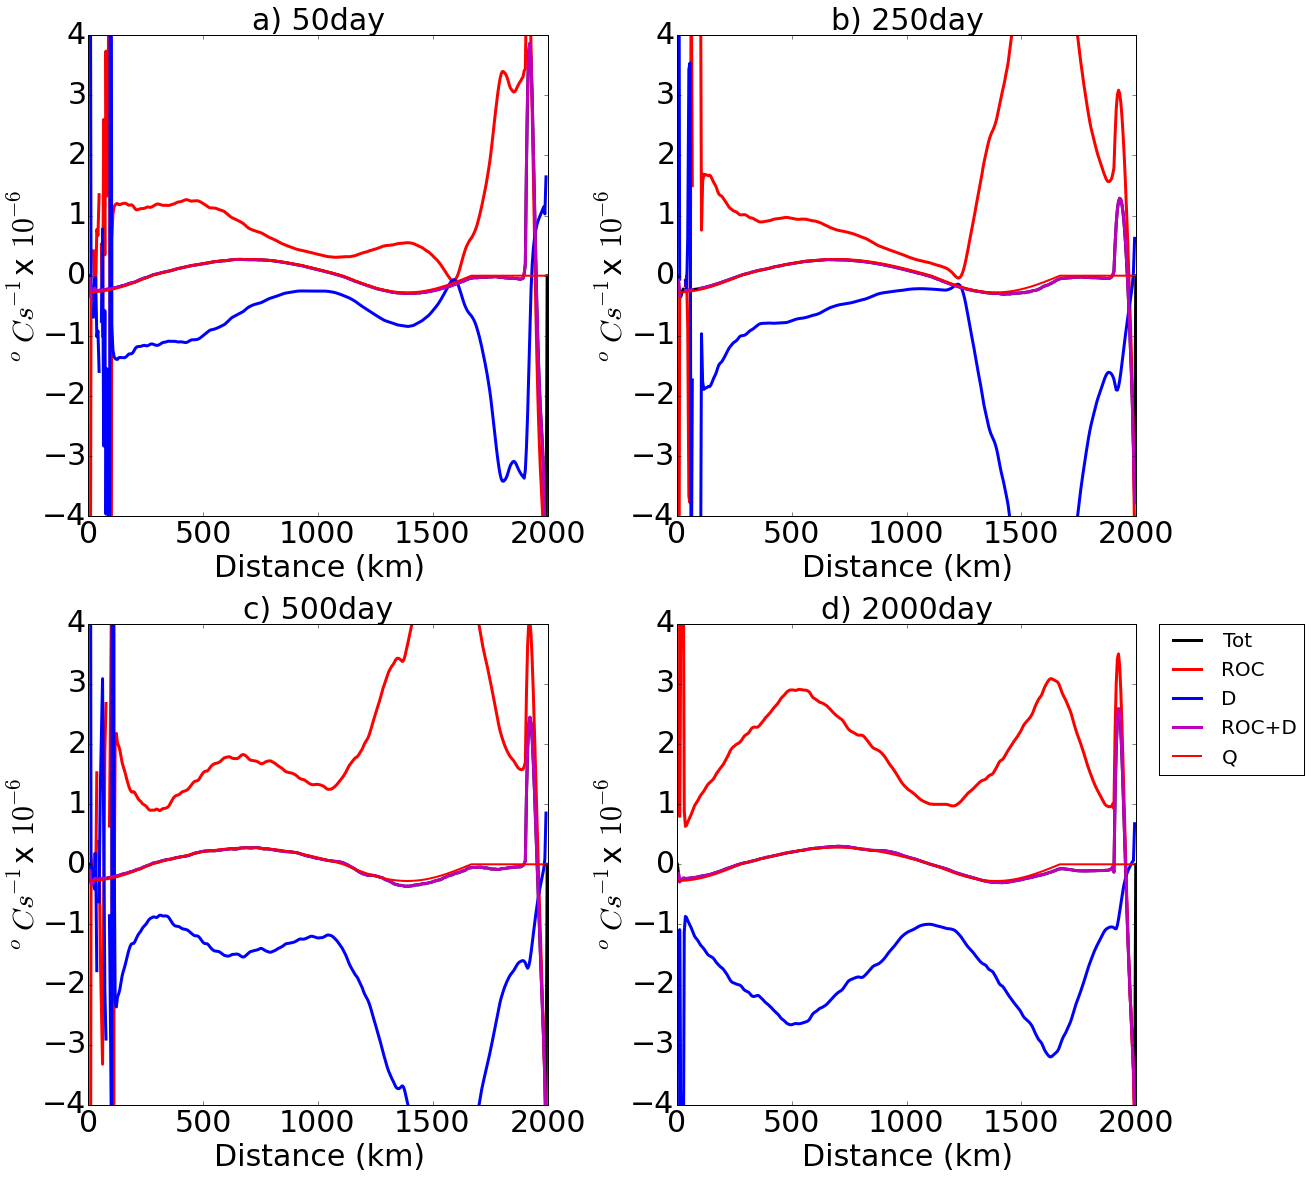

In [8]:
fig = plt.figure(figsize=(16.5, 16.5))
for i in range(len(Runs)):

    fname = x+'/'+str(tau[Runs[i]])+'m/'
    c = utils.ChannelSetup(output_dir=str(fname))
    # PLOT PANNELS
    CellVol = c.rac*tile(c.dzf,(c.Nx,c.Ny,1)).T
    Nx,Ny,Nz = c.Nx, c.Ny, c.Nz
    # load V, W, T bar    
    # put everything on the C Grid                        
    VT = (c.mnc('Tav_VT.nc','VVELTH'))
    WT = (c.mnc('Tav_VT.nc','WVELTH'))
    Tv = c.cgrid_to_vgrid(c.mnc('Tav.nc','THETA'))
    Tw = c.cgrid_to_wgrid(c.mnc('Tav.nc','THETA'))
    V = (c.mnc('Tav.nc','VVEL'))
    W = (c.mnc('Tav.nc','WVEL'))
    VTbar = V*Tv
    WTbar = W*Tw
    VpTp = VT - VTbar
    WpTp = WT - WTbar
    # Vertical Mass-Weight Transp of Pot Temp (K.m/s)
    WTHMASS = c.mnc('SURF.nc', 'WTHMASS')
    # Surface cor
    Surcor = (WTHMASS.mean(axis=0)).mean(axis=1)
    dVTbar = (VTbar[:,0:-1,:] - VTbar[:,1::,:])*CellVol
    dWTbar = (WTbar[1::,:,:] - WTbar[0:-1,:,:])*CellVol[0:-1,:,:]
    dVTe = (VpTp[:,0:-1,:] - VpTp[:,1::,:])*CellVol
    dWTe = (WpTp[1::,:,:] - WpTp[0:-1,:,:])*CellVol[0:-1,:,:]
    Ty = (Tv[:,0:-1,:] - Tv[:,1::,:])*CellVol
    Tz = (Tw[1::,:,:] - Tw[0:-1,:,:])*CellVol[0:-1,:,:]
    Sp = zeros((c.Nz,c.Ny,c.Nx))
    Sp[0:-1,:,:] = -Ty[0:-1,:,:]/Tz
    Ade = ((c.vgrid_to_cgrid(VpTp)*Sp)[1::,:,:] 
           - (c.vgrid_to_cgrid(VpTp)*Sp)[0:-1,:,:])*CellVol[0:-1,:,:] 
    DE = ((WpTp-(c.vgrid_to_cgrid(VpTp)*Sp))[1::,:,:] 
          - (WpTp-(c.vgrid_to_cgrid(VpTp)*Sp))[0:-1,:,:])*CellVol[0:-1,:,:] 
    D = -5000*((DE.sum(axis=0))/sum(CellVol)).mean(axis=1)
    ROC =-5000*((Ade.sum(axis=0) + dVTe.sum(axis=0) 
                 + dVTbar.sum(axis=0) + dWTbar.sum(axis=0))/sum(CellVol)).mean(axis=1)
    Adv = ((dVTe.sum(axis=0) + dWTe.sum(axis=0)
           + dVTbar.sum(axis=0) + dWTbar.sum(axis=0))/sum(CellVol))
    Adv = (dVTe.sum(axis=0) + dWTe.sum(axis=0) + dVTbar.sum(axis=0) + dWTbar.sum(axis=0))/sum(CellVol)
    Diff = -(5000*Adv).mean(axis=1)
    Ly = 2000e3
    Lx = 1000e3
    nx = np.round(Lx/5000)
    ny = np.round(Ly/5000)
    Q_0 = 10
    Q = np.zeros_like(c.yc)
    pi = math.pi
    Q=np.zeros(np.shape(Q))
    Q[0:int(5*ny/36)] = Q_0*(np.cos(c.yc[0:int(5*ny/36)]*(pi/(c.yc[int(10*ny/36)]))))
    Q[int(5*ny/36):int(20*ny/36)] = -Q_0*(np.sin((c.yc[int(5*ny/36):int(20*ny/36)]
                                                  -c.yc[int(5*ny/36)])*(pi/(c.yc[int(15*ny/36)]))))
    Q[int(20*ny/36):int(30*ny/36)] = Q_0*(np.sin(c.yc[0:int(10*ny/36)]*(pi/(c.yc[int(10*ny/36)]))))
    Psipred = -(Q)/(1000*3985)
    ax = fig.add_subplot(2, 2, i+1)
    p = plt.plot(c.yc/1000,(Diff+Surcor)*10**6,'k',linewidth=3)
    p = plt.plot(c.yc/1000,(ROC)*10**6,'r',linewidth=3)
    p = plt.plot(c.yc/1000,(D)*10**6,'b',linewidth=3)
    p = plt.plot(c.yc/1000,(ROC+D+Surcor)*10**6,'m',linewidth=3)
    p = plt.plot(c.yc/1000,(Psipred/c.dzf[6])*10**6,'r',linewidth=2)
    plt.ylim(-4,4)
    ax.set_title(str(Figletter[Runs[i]])+str(tau[Runs[i]])+'day', fontsize=30)
    if str(tau[Runs[i]]) == 'Closed':
        ax.set_title(str(Figletter[Runs[i]])+str(tau[Runs[i]]), fontsize=30)
    ax.set_xlabel('Distance (km)', fontsize=30)
    ax.set_ylabel(r'$^oCs^{-1}$x $10^{-6}$', fontsize=30)
    ax.tick_params(axis='both', which='major', labelsize=30)
lgd = plt.legend([r'Tot','ROC','D','ROC+D','Q',
                  'Q'],bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.,fontsize=20)
plt.tight_layout()

## Cartesian mixed layer depth

/noc/users/hb1g13/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:32: RuntimeWarning: divide by zero encountered in divide
/noc/users/hb1g13/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:32: RuntimeWarning: invalid value encountered in divide
/noc/users/hb1g13/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:45: RuntimeWarning: invalid value encountered in multiply
/noc/users/hb1g13/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:46: RuntimeWarning: invalid value encountered in multiply
/noc/users/hb1g13/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:47: RuntimeWarning: invalid value encountered in multiply
/noc/users/hb1g13/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:48: RuntimeWarning: invalid value encountered in multiply


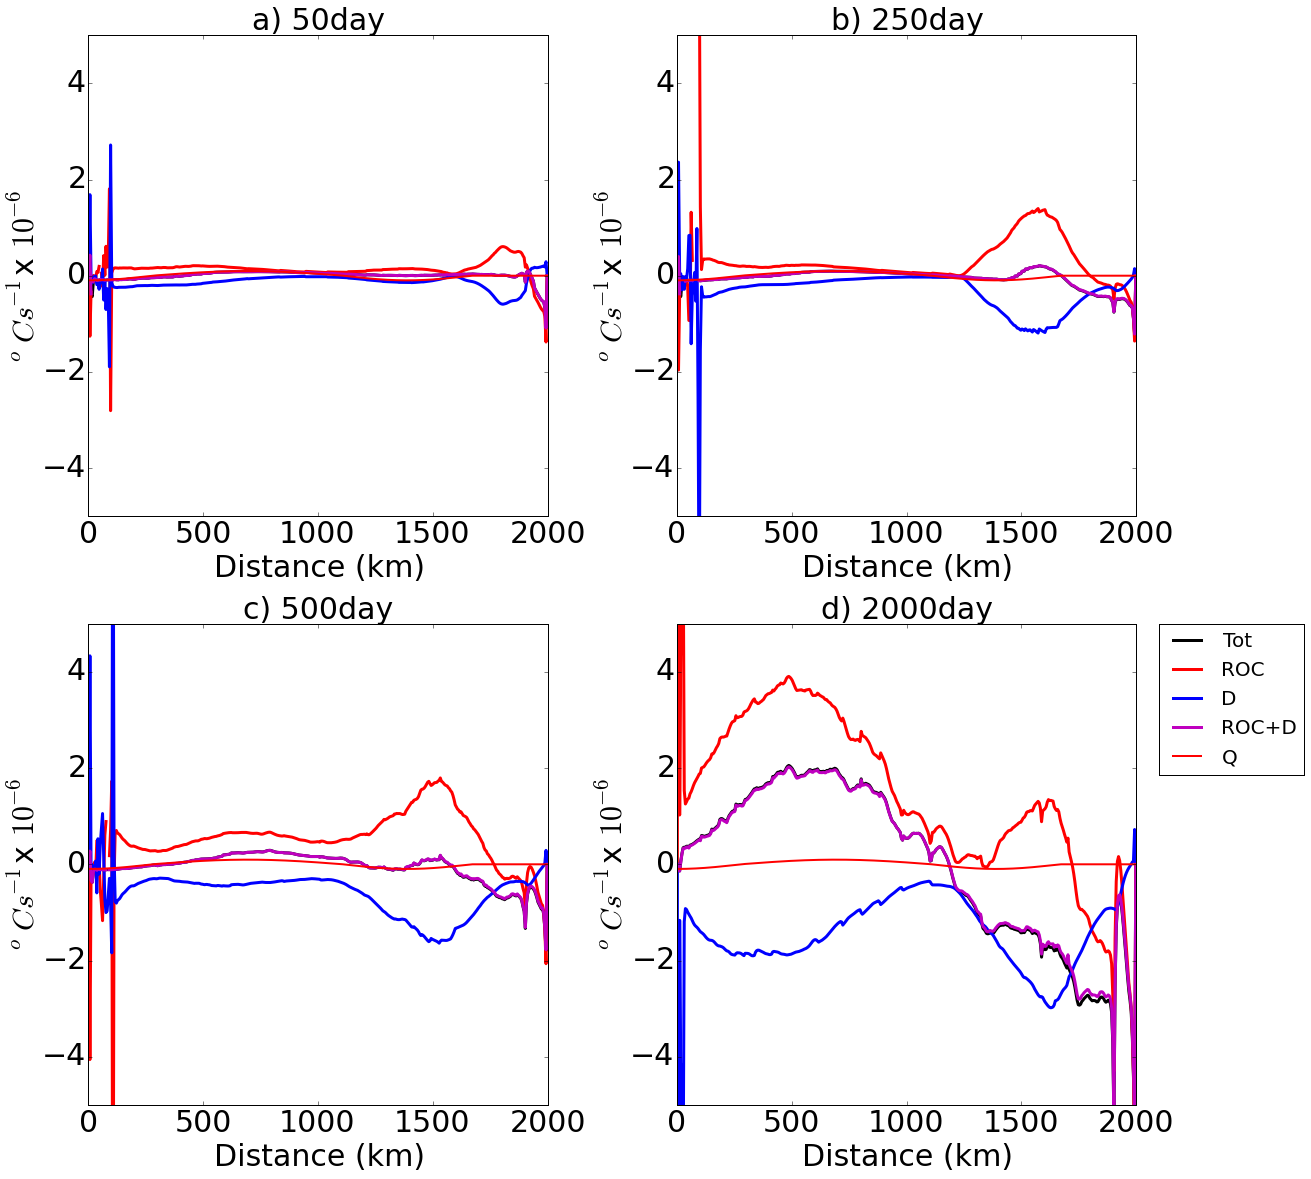

In [21]:
fig = plt.figure(figsize=(16.5, 16.5))
for i in range(len(Runs)):
    fname = x+'/'+str(tau[Runs[i]])+'m/'
    c = utils.ChannelSetup(output_dir=str(fname))
    # PLOT PANNELS
    CellVol = c.rac*tile(c.dzf,(c.Nx,c.Ny,1)).T
    Nx,Ny,Nz = c.Nx, c.Ny, c.Nz
    # load V, W, T bar    
    # put everything on the C Grid                        
    VT = (c.mnc('Tav_VT.nc','VVELTH'))
    WT = (c.mnc('Tav_VT.nc','WVELTH'))
    Tv = c.cgrid_to_vgrid(c.mnc('Tav.nc','THETA'))
    Tw = c.cgrid_to_wgrid(c.mnc('Tav.nc','THETA'))
    V = (c.mnc('Tav.nc','VVEL'))
    W = (c.mnc('Tav.nc','WVEL'))
    MLD = (c.mnc('MLD.nc','MXLDEPTH')).mean(axis=0)
    VTbar = V*Tv
    WTbar = W*Tw
    VpTp = VT - VTbar
    WpTp = WT - WTbar
    mxlvol = c.rac*MLD
    WTHMASS = c.mnc('SURF.nc', 'WTHMASS')
    # Surface cor
    Surcor = (WTHMASS.mean(axis=0)).mean(axis=1)
    dVTbar = (VTbar[:,0:-1,:] - VTbar[:,1::,:])*CellVol
    dWTbar = (WTbar[1::,:,:] - WTbar[0:-1,:,:])*CellVol[0:-1,:,:]
    dVTe = (VpTp[:,0:-1,:] - VpTp[:,1::,:])*CellVol
    dWTe = (WpTp[1::,:,:] - WpTp[0:-1,:,:])*CellVol[0:-1,:,:]
    Ty = (Tv[:,0:-1,:] - Tv[:,1::,:])*CellVol
    Tz = (Tw[1::,:,:] - Tw[0:-1,:,:])*CellVol[0:-1,:,:]
    Sp = zeros((c.Nz,c.Ny,c.Nx))
    Sp[0:-1,:,:] = -Ty[0:-1,:,:]/Tz
    Zmatrix = tile(c.zc,(c.Nx,c.Ny,1)).T
    Zpmatrix = tile(c.zf,(c.Nx,c.Ny,1)).T
    Mxmask = zeros_like(Zmatrix)
    Mxpmask = zeros_like(Zpmatrix)
    for ii in range(c.Nx-1):
        for jj in range(c.Ny-1):
            I=find_nearest(c.zc, -MLD[jj,ii])
            b=nonzero(c.zc==I)[0][0]
            Mxmask[0:b,jj,ii] = 1
            I=find_nearest(c.zf, -MLD[jj,ii])
            b=nonzero(c.zf==I)[0][0]
            Mxpmask[0:b,jj,ii] = 1
    Ade = ((c.vgrid_to_cgrid(VpTp)*Sp*Mxmask)[1::,:,:] 
           - (c.vgrid_to_cgrid(VpTp)*Sp*Mxmask)[0:-1,:,:])*(Mxmask*CellVol)[0:-1,:,:] 
    DE = ((c.wgrid_to_cgrid(WpTp)-(c.vgrid_to_cgrid(VpTp)*Sp)*Mxmask)[1::,:,:] 
          - (c.wgrid_to_cgrid(WpTp)-(c.vgrid_to_cgrid(VpTp)*Sp)*Mxmask)[0:-1,:,:])*(CellVol*Mxmask)[0:-1,:,:] 


    D = -5000*np.nanmean(((np.nansum(DE,axis=0))/sum(mxlvol)),axis=1)
    ROC =-5000*((np.nansum(Ade,axis=0) + (Mxmask*dVTe).sum(axis=0) 
                 + (Mxmask*dVTbar).sum(axis=0) + (Mxpmask[0:-2]*dWTbar).sum(axis=0))/sum(mxlvol)).mean(axis=1)
    Adv = (((Mxmask*dVTe).sum(axis=0) + (Mxpmask[0:-2]*dWTe).sum(axis=0)+ (Mxmask*dVTbar).sum(axis=0) 
           + dWTbar.sum(axis=0))/sum(mxlvol))
    Diff = -(5000*Adv).mean(axis=1)
    Ly = 2000e3
    Lx = 1000e3
    nx = np.round(Lx/5000)
    ny = np.round(Ly/5000)
    Q_0 = 10
    Q = np.zeros_like(c.yc)
    pi = math.pi
    Q=np.zeros(np.shape(Q))
    Q[0:int(5*ny/36)] = Q_0*(np.cos(c.yc[0:int(5*ny/36)]*(pi/(c.yc[int(10*ny/36)]))))
    Q[int(5*ny/36):int(20*ny/36)] = -Q_0*(np.sin((c.yc[int(5*ny/36):int(20*ny/36)]
                                                  -c.yc[int(5*ny/36)])*(pi/(c.yc[int(15*ny/36)]))))
    Q[int(20*ny/36):int(30*ny/36)] = Q_0*(np.sin(c.yc[0:int(10*ny/36)]*(pi/(c.yc[int(10*ny/36)]))))
    Psipred = -(Q)/(1000*3985)
    ax = fig.add_subplot(2, 2, i+1)
    p = plt.plot(c.yc/1000,(Diff+Surcor)*10**5,'k',linewidth=3)
    p = plt.plot(c.yc/1000,(ROC)*10**5,'r',linewidth=3)
    p = plt.plot(c.yc/1000,(D)*10**5,'b',linewidth=3)
    p = plt.plot(c.yc/1000,(ROC+D+Surcor)*10**5,'m',linewidth=3)
    p = plt.plot(c.yc/1000,(Psipred/c.dzf[0])*10**5,'r',linewidth=2)
    plt.ylim(-5,5)
    ax.set_title(str(Figletter[Runs[i]])+str(tau[Runs[i]])+'day', fontsize=30)
    if str(tau[Runs[i]]) == 'Closed':
        ax.set_title(str(Figletter[Runs[i]])+str(tau[Runs[i]]), fontsize=30)
    ax.set_xlabel('Distance (km)', fontsize=30)
    ax.set_ylabel(r'$^oCs^{-1}$x $10^{-6}$', fontsize=30)
    ax.tick_params(axis='both', which='major', labelsize=30)
lgd = plt.legend([r'Tot','ROC','D','ROC+D','Q',
                  'Q'],bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.,fontsize=20)
plt.tight_layout()

#Residual mean full depth

\begin{equation}
J(\psi_{res},\overline{T})=\frac{\partial B}{\partial z}- \frac{\partial \left(\overline{w'T'}-S_p.\overline{v'T'}\right)}{\partial z },
\end{equation} 

\begin{equation}
J(\Psi_{res},\overline{T}) = \underbrace{\frac{\partial B}{\partial z}}_\text{Air-sea fluxes} - \underbrace{\frac{\partial \overline{w'T' - \Psi ^*. T_z.S_p  }}{\partial z }}_\text{Diabatic eddies} 
\end{equation} 

#Residual mean mixed layer depth

\begin{equation}
   \Psi_{res}  |_{hml}   =  \left( Q + \int_{-hml}^{0}\frac{\partial \left(w'T' - \overline{v'T'}.Sp  \right)}{\partial z} \mathrm{d}z \right) \left(  \frac{\partial \overline{b} }{\partial y }  \right)^{-1} 
\end{equation}